## Pytorch tutorial 2
- 기본 modeling, NN layer 쌓기 및 metric 등 `torch.nn`의 모듈 및 기능에 대해 알아봅니다. 

In [30]:
import os
import sys
import pandas as pd
import numpy as np
import torch

In [31]:
import torch.nn as nn
import torch.nn.functional as F

# Pytorch Graph
`torch.nn` 모듈은 텐서 그래프를 생성하는 다양한 함수를 제공한다. 

[OFFICAL DOCUMENT](https://pytorch.org/docs/stable/nn.html)

# Table of Contents
1. [Container](#Container)
2. [Layers](#Layers)
3. [Loss](#Loss)
4. [추가](#To-Learn-More..)




## Container
- [OFFICIAL DOC](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#module)

### `Module` class 
- Neural Network를 생성할 때 반드시 `Module` 클래스를 부모 클래스로 상속받아야 함
- `Module` 부모 클래스의 변수 및 메소드 사용 가능 (ex. `eval()`, `train()`, `parameters()`, `state_dict()`, `to()`)
  - `train()` : require_gradient=True 가 됨, backprop이 자동적으로 됨
  - `parameters()`: 학습중인 parameter 및 weight 정보 확인
  - `to()`) : 학습시 이용할 Processor 선택(CPU or GPU,..)
- `forward()` 메소드는 모든 자식클래스에서 반드시 **오버라이딩** 해야함
- [출처](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module)

<img src="https://github.com/ChristinaROK/PreOnboarding_AI_assets/blob/36a670a7b6233d5218a495150beb337a899ecb70/week2/week2_2_model.jpeg?raw=true" alt="model" width=600>


In [32]:
class Model(nn.Module):
    def __init__(self, input_shape):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_shape, 32)
        self.layer2 = nn.Linear(32, 64)
        self.layer_out = nn.Linear(64,1)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer_out(x)
        return x

In [33]:
model = Model(30)

for param in model.parameters():
    print(param.shape)

for name, state in model.state_dict().items():
    print(f"{name} -> size : {state.shape}")

torch.Size([32, 30])
torch.Size([32])
torch.Size([64, 32])
torch.Size([64])
torch.Size([1, 64])
torch.Size([1])
layer1.weight -> size : torch.Size([32, 30])
layer1.bias -> size : torch.Size([32])
layer2.weight -> size : torch.Size([64, 32])
layer2.bias -> size : torch.Size([64])
layer_out.weight -> size : torch.Size([1, 64])
layer_out.bias -> size : torch.Size([1])


In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda


Model(
  (layer1): Linear(in_features=30, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

### `Sequntial` class
- 여러 layer를 연결한 container
- 이전 layer의 output이 다음 layer의 input으로 입력됨 (순차적)
- [출처](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential)

In [35]:
model = nn.Sequential(
          nn.Linear(30, 32),
          nn.ReLU(),
          nn.Linear(32,64),
          nn.ReLU(),
          nn.Linear(64,1)
        )

In [36]:
model.eval()

Sequential(
  (0): Linear(in_features=30, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=1, bias=True)
)

## Layers
- Linear()
    - `input @ weight.T + bias`
- LSTM()
    - [OFFICAL DOCS](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM) 
    - nn.LSTM(`input_size`, `hidden_size`)
        - nn.LSTM()(`input`, (`h_0`, `c_0`))
        - `input` shape: (문장 길이, 배치 사이즈, 단어 엠베딩 사이즈 == input_size)
        - `hidden_size` shape: (lstm 개수 * 레이어 수 , 배치 사이즈, 히든 사이즈 == hidden size)
    - <img src="https://github.com/ChristinaROK/PreOnboarding_AI_assets/blob/36a670a7b6233d5218a495150beb337a899ecb70/week2/week2_2_lstm.png?raw=true" width=500>
    - [출처](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
    

In [37]:
model = nn.Linear(20,30) 
print(f"W shape: {model.weight.shape}")
print(f"bias shape: {model.bias.shape}")

W shape: torch.Size([30, 20])
bias shape: torch.Size([30])


In [38]:
ex = "I love coding . Just kidding ."
inputs = ex.split()
print(inputs)

['I', 'love', 'coding', '.', 'Just', 'kidding', '.']


In [39]:
input_embedding = [torch.randn(1, 5) for _ in range(len(inputs))]

lstm = nn.LSTM(5,5) # (input dim, output dim)
hidden = (
    torch.randn(1,1,5), # (모든 레이어의 lstm 개수, batch size, hidden_size)
    torch.randn(1,1,5),
)

# 한 단어씩 입력
for idx, i in enumerate(input_embedding):
    out, hidden = lstm(i.view(1,1,-1), hidden)
    print(f"{idx+1} word : output shape ({out.shape}) / hidden state shape ({hidden[0].shape})")

assert out.detach().equal(hidden[0].detach())

print("----------------------------------")

# sequence를 입력
input_embedding = torch.cat(input_embedding).view(len(inputs), 1, -1)
print(f"input sequence shape : {input_embedding.shape}")
hidden = (
    torch.randn(1,1,5), # (모든 레이어의 lstm 개수, batch size, hidden_size)
    torch.randn(1,1,5),
)
out, hidden = lstm(input_embedding, hidden)
print(f"output shape : {out.shape}")
print(f"hidden shape : {hidden[0].shape}")

assert out[-1, : , :].detach().equal(hidden[0][-1, :,:].detach())

1 word : output shape (torch.Size([1, 1, 5])) / hidden state shape (torch.Size([1, 1, 5]))
2 word : output shape (torch.Size([1, 1, 5])) / hidden state shape (torch.Size([1, 1, 5]))
3 word : output shape (torch.Size([1, 1, 5])) / hidden state shape (torch.Size([1, 1, 5]))
4 word : output shape (torch.Size([1, 1, 5])) / hidden state shape (torch.Size([1, 1, 5]))
5 word : output shape (torch.Size([1, 1, 5])) / hidden state shape (torch.Size([1, 1, 5]))
6 word : output shape (torch.Size([1, 1, 5])) / hidden state shape (torch.Size([1, 1, 5]))
7 word : output shape (torch.Size([1, 1, 5])) / hidden state shape (torch.Size([1, 1, 5]))
----------------------------------
input sequence shape : torch.Size([7, 1, 5])
output shape : torch.Size([7, 1, 5])
hidden shape : torch.Size([1, 1, 5])


## Activation
- nonlinear activations

In [40]:
nn.LeakyReLU()
nn.ReLU()
nn.Sigmoid()
nn.GELU()
nn.Tanh()
nn.Softmax()

Softmax(dim=None)

## Loss
- loss = loss_class()
    - loss(`y_hat`, `y`)
    - `loss().backward()`
- Mean Square Error Loss 
    - <img src="https://github.com/ChristinaROK/PreOnboarding_AI_assets/blob/36a670a7b6233d5218a495150beb337a899ecb70/week2/week2_2_mse.png?raw=true" width=200>
- Cross Entropy Loss 
    - <img src="https://github.com/ChristinaROK/PreOnboarding_AI_assets/blob/36a670a7b6233d5218a495150beb337a899ecb70/week2/week2_2_ce.png?raw=true" width=200>
- Binary Cross Entropy Loss 
    - <img src="https://github.com/ChristinaROK/PreOnboarding_AI_assets/blob/36a670a7b6233d5218a495150beb337a899ecb70/week2/week2_2_bce.png?raw=true" width=500>

In [41]:
# l2 distance loss
nn.MSELoss()
nn.NLLLoss()

# cross entropy
## multi class
nn.CrossEntropyLoss() # softmax O

## binary class
nn.BCELoss()
nn.BCEWithLogitsLoss() # sigmoid O + BCELoss()

BCEWithLogitsLoss()

In [42]:
batch_size = 3
C = 5
logits = torch.randn(batch_size, C, requires_grad=True)
print(f"Logits : {logits}")

loss = nn.CrossEntropyLoss()

target = torch.empty(batch_size, dtype = torch.long).random_(C)
print(f"Target: {target}")

loss = loss(logits, target)
print(f"Loss : {loss}")

loss.backward()

Logits : tensor([[ 0.6922, -0.2898,  1.9678, -0.7601, -0.5966],
        [ 0.6723,  0.2559, -0.1515,  0.3215,  0.8197],
        [ 0.0351,  0.2557,  0.5999, -0.6656, -0.1431]], requires_grad=True)
Target: tensor([3, 1, 4])
Loss : 2.265610933303833


## To Learn More...

In [ ]:
# dropout
nn.Dropout()
# normalization
nn.BatchNorm1d()

In [ ]:
# gradient clipping
nn.utils.clip_grad()
# weight normalizing
nn.utils.weight_norm()

### Parallel
- 여러 gpu, 또는 여러 머신에서 입력 데이터를 분산 처리를 가능하게 함

In [ ]:
nn.DataParallel()
nn.parallel.DistributedDataParallel()

# [Appendix]
### 오버라이딩이란?

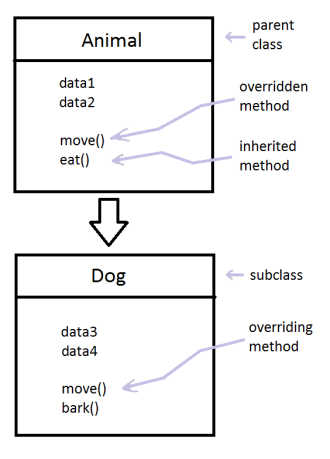

- 자식클래스에서 부모클래스의 메소드명과 같은 메소드를 정의해줌으로서 새로운 기능을 정의해 줌. 



In [ ]:
class Thought(object):
    def __init__(self):
        pass
    def message(self):
        print ("I feel like I am diagonally parked in a parallel universe.")



class Advice(Thought):
    def __init__(self):
        super(Advice, self).__init__()
    @classmethod
    def message(self):
        print ("Warning: Dates in calendar are closer than they appear")
        super(Advice, self).message(self) # 부모클래스 호출하는 법

Advice().message()

### Statismethod, Classmethod
`@staticmethod` : 상속되면 부모 클래스 parameter(method, attribute)를 따름
`@classmethod` : 자식클래스 parameter(method, attribute)를 따름

In [ ]:
class foo:
  name='foo'
  @staticmethod
  def get_name_static():
    return foo.name
  @classmethod
  def get_name_class(cls):
    return cls.name
foo.get_name_static(), foo.get_name_class()

In [ ]:
class foofoo(foo):
  name='foofoo'
foofoo.get_name_static(), foofoo.get_name_class()